# Imports

In [26]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from path_explain import PathExplainerTF, scatter_plot, summary_plot, softplus_activation
from path_explain.utils import set_up_environment

In [2]:
set_up_environment(visible_devices='3')

# Loading the Data

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data()

In [4]:
scaler = StandardScaler()

In [5]:
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled  = scaler.transform(x_test)

# Training the Model

In [6]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(13,)))
model.add(tf.keras.layers.Dense(units=32, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=32, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(units=1,  activation=None))

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
loss = tf.keras.losses.MeanSquaredError()
metrics = [tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()]
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
model.fit(x_train_scaled, y_train, batch_size=64, epochs=50, verbose=0)
train_loss, train_mse, train_mae = model.evaluate(x_train_scaled, y_train, batch_size=64, verbose=0)
test_loss, test_mse, test_mae = model.evaluate(x_test_scaled, y_test, batch_size=64, verbose=0)

In [7]:
print('Train MSE: {:.4f}\tTrain MAE: {:.4f}'.format(train_mse, train_mae))
print('Test MSE: {:.4f}\tTest MAE: {:.4f}'.format(test_mse, test_mae))

Train MSE: 5.6867	Train MAE: 1.6980
Test MSE: 17.6739	Test MAE: 2.6637


In [8]:
y_pred = model.predict(x_test_scaled)

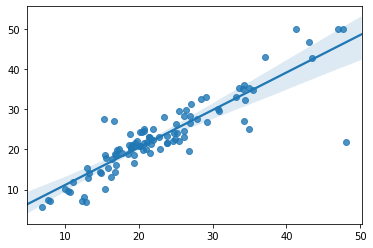

In [9]:
sns.regplot(y_pred[:, 0], y_test)

# Interpreting the Model

The first step in interpreting a ReLU-based model is changing the activations to softplus. The justification for doing this is discussed in the original paper, but in code this is fairly simple to do. First we clone the model, and then we manually change the activation function!

In [27]:
interpret_model = tf.keras.models.clone_model(model)
interpret_model.layers[0].activation = softplus_activation(beta=10.0)
interpret_model.layers[1].activation = softplus_activation(beta=10.0)

The next step is to define our explainer object.

In [29]:
explainer = PathExplainerTF(interpret_model)

Now we actually have to run the attribution function. Here we used expected gradients because the argument `use_expectation` is equal to true and the baseline is set to be the training data. However, we could set `use_expectation` and the baseline to be the zeros vector to use integrated gradients instead.

In [30]:
attributions = explainer.attributions(inputs=x_test_scaled.astype(np.float32),
                                      baseline=x_train_scaled.astype(np.float32),
                                      batch_size=100,
                                      num_samples=200,
                                      use_expectation=True,
                                      output_indices=0,
                                      verbose=True)

100%|██████████| 102/102 [00:01<00:00, 60.61it/s]


The code to generate interactions takes the same arguments as the code to generate attributions. This makes generating interactions nice and easy! Here we are using expected hessians to generate interactions, but we can also use integrated hessians by changing the same arguments mentioned above.

In [31]:
interactions = explainer.interactions(inputs=x_test_scaled.astype(np.float32),
                                      baseline=x_train_scaled.astype(np.float32),
                                      batch_size=100,
                                      num_samples=200,
                                      use_expectation=True,
                                      output_indices=0,
                                      verbose=True)

100%|██████████| 102/102 [03:29<00:00,  2.05s/it]


In [13]:
# Taken from https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

First, we do a summary plot of all the attributions. To give credit where credit is due, most of the plotting libraries here are based off of the [SHAP package](https://github.com/slundberg/shap). Thanks Scott :)

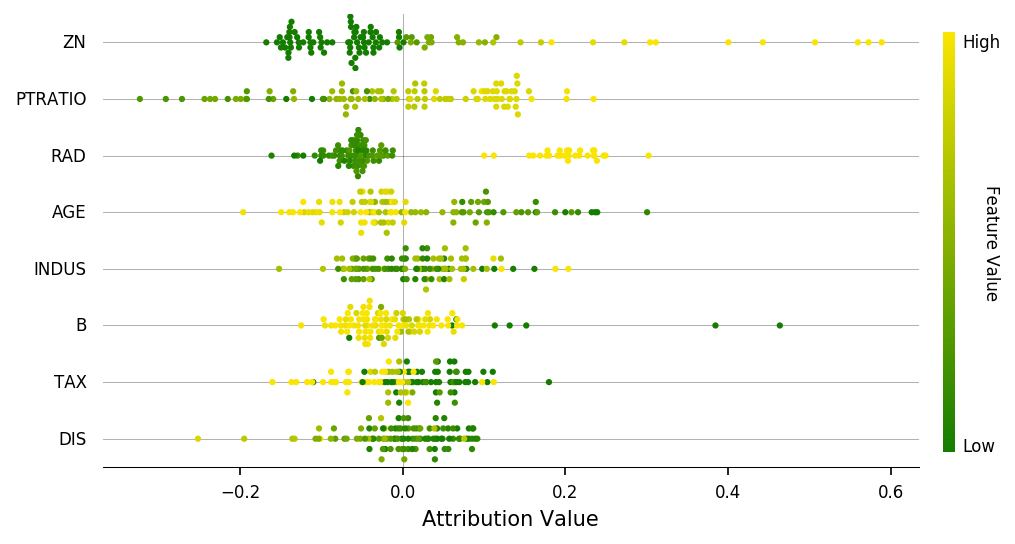

In [35]:
summary_plot(attributions,
             x_test,
             feature_names=feature_names,
             plot_top_k=8)

Next, we plot the attributions and interactions of a specific feature. We can see some interesting patterns that our model has learned!

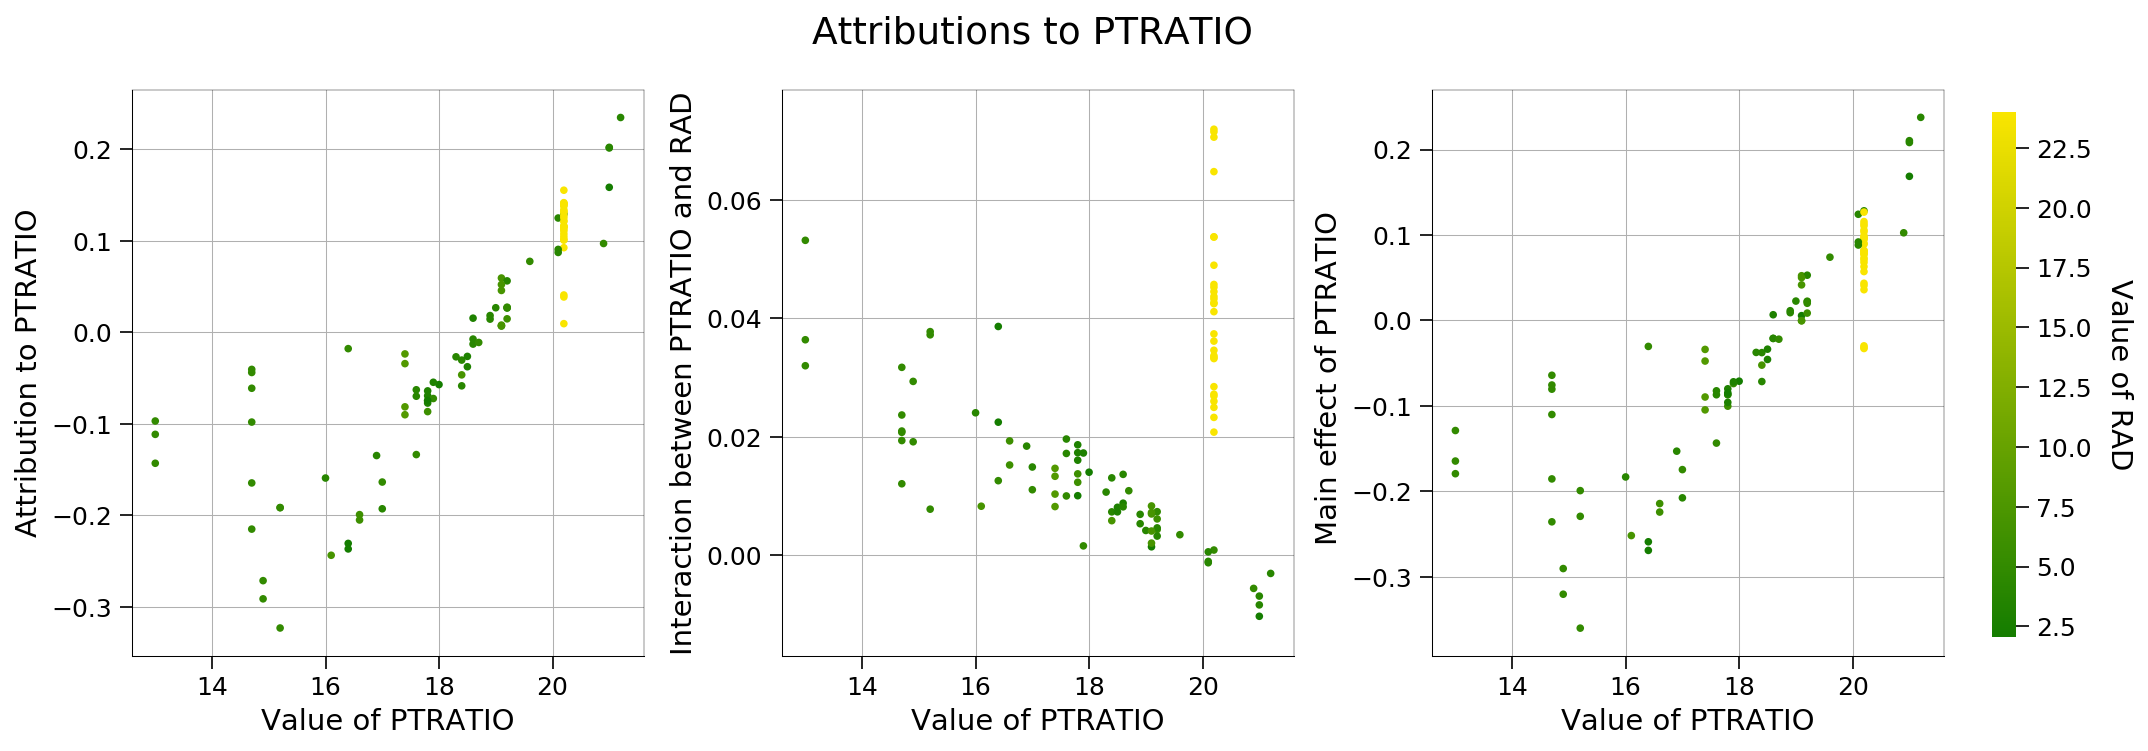

In [38]:
fig, axs = scatter_plot(attributions,
                        x_test,
                        feature_index='PTRATIO',
                        interactions=interactions,
                        color_by='RAD',
                        feature_names=feature_names,
                        scale_y_ind=True)